М. Подрядчикова, МКЛ181

# Данные

In [1]:
!wget https://www.dropbox.com/s/nd7v1fod89xla6j/vk_texts_with_sources.csv

--2019-03-04 16:12:40--  https://www.dropbox.com/s/nd7v1fod89xla6j/vk_texts_with_sources.csv
Распознаётся www.dropbox.com (www.dropbox.com)… 162.125.70.1, 2620:100:6026:1::a27d:4601
Подключение к www.dropbox.com (www.dropbox.com)|162.125.70.1|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 301 Moved Permanently
Адрес: /s/raw/nd7v1fod89xla6j/vk_texts_with_sources.csv [переход]
--2019-03-04 16:12:40--  https://www.dropbox.com/s/raw/nd7v1fod89xla6j/vk_texts_with_sources.csv
Повторное использование соединения с www.dropbox.com:443.
HTTP-запрос отправлен. Ожидание ответа… 302 Found
Адрес: https://uc5ea943c48f8f86209d6fead8dc.dl.dropboxusercontent.com/cd/0/inline/AcckHEqLuiESgG3ZmjL3kZigmO-01_HA-LRqL3kn4vRXkQdje6IE464w1hhKi90CPpC7--37lVCs9-LVJJX7Ta0JefkMBaEF-qGHktA68UO9v-LGFLCEiUJTg3EfZRFi3og/file# [переход]
--2019-03-04 16:12:41--  https://uc5ea943c48f8f86209d6fead8dc.dl.dropboxusercontent.com/cd/0/inline/AcckHEqLuiESgG3ZmjL3kZigmO-01_HA-LRqL3kn4vRXkQdje6IE464w1hhKi9

In [65]:
from nltk.tokenize import word_tokenize
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
from string import punctuation
punct = punctuation+'«»—…“”*№–'
from nltk.corpus import stopwords
stops = set(stopwords.words('russian'))
import numpy as np
from string import punctuation
punct = punctuation+'«»—…“”*№–'

def normalize(words):
    
    words = [morph.parse(word)[0] for word in words if word and word not in stops]
    words = [word.normal_form for word in words if word.tag.POS == 'NOUN']

    return words

def normalize_text(text):
    
    words = [word.strip(punct) for word in text.lower().split()]
    words = [morph.parse(word)[0].normal_form for word in words if word and word not in stops]

    return words

In [66]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import *
from sklearn.pipeline import *
from sklearn.preprocessing import Normalizer
from sklearn.metrics import *
from sklearn.cluster import *
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import *

In [67]:
import pandas as pd
df = pd.read_csv('vk_texts_with_sources.csv', usecols = ['text', 'source'])
df.head()

,text,source
0,Начальник Главного оперативного управления Ген...,mil
1,Артиллерийские подразделения общевойскового об...,mil
2,Подразделения морской пехоты Каспийской флотил...,mil
3,Команды на всеармейских этапах конкурсов АрМИ-...,mil
4,На большом учебно-методическом командирском сб...,mil


# Домашнее задание 1 

В этом домашнем задании вы будете решать задачу тематической классификации. Даны тексты, опубликованные в нескольких пабликах VK.com, посвященных государственным и муниципальным службам. Формально задача заключается в том, чтобы по тексту ($d$) определить в каком паблике он опубликован, то есть, к какому классу $c$ он принадлежит. 

## Задание 1 [2 балла]. Описательные статистики
Посчитайте:
* количество текстов и количество классов
* количество слов (без лемматизации и с лемматизацией) в коллекции
* среднюю длину текста в словах и символах
* найдите 5 самых частых существительных в текстах каждого паблика 

*Рекомендуем использовать pandas для расчета описательных статистик.*

В ходе попытки подсчитать количество символов для каждого текста выяснилось, что есть пустые строки, поэтому сначала оставим в датафрейме только те строки, для которых вообще есть текст. 

In [68]:
df = df.dropna()

Считаем количество текстов.

In [69]:
len(df["text"])

11526

Считаем количество классов. 

In [70]:
clsses = []
for c in df["source"]:
    if c not in clsses:
        clsses.append(c)

clsses, len(clsses)

(['mil', 'mchsgov', 'russianpost', 'mospolice'], 4)

Считаем количество слов в коллекции. 

In [71]:
df["words"] = df["text"]
df.head()

,text,source,words
0,Начальник Главного оперативного управления Ген...,mil,Начальник Главного оперативного управления Ген...
1,Артиллерийские подразделения общевойскового об...,mil,Артиллерийские подразделения общевойскового об...
2,Подразделения морской пехоты Каспийской флотил...,mil,Подразделения морской пехоты Каспийской флотил...
3,Команды на всеармейских этапах конкурсов АрМИ-...,mil,Команды на всеармейских этапах конкурсов АрМИ-...
4,На большом учебно-методическом командирском сб...,mil,На большом учебно-методическом командирском сб...


In [72]:
def word_counter_text(column):
    all_words = []
    for i, text in enumerate(column):
        text = word_tokenize(text)
        text = [word.lower().strip(punct) for word in text if word != "br" and word.strip(punct)]
        column.iloc[i] = text
        all_words += text
    return all_words 

words = word_counter_text(df["words"])
len(words), len(set(words))

(979592, 84733)

In [73]:
df.head()

,text,source,words
0,Начальник Главного оперативного управления Ген...,mil,"[начальник, главного, оперативного, управления..."
1,Артиллерийские подразделения общевойскового об...,mil,"[артиллерийские, подразделения, общевойскового..."
2,Подразделения морской пехоты Каспийской флотил...,mil,"[подразделения, морской, пехоты, каспийской, ф..."
3,Команды на всеармейских этапах конкурсов АрМИ-...,mil,"[команды, на, всеармейских, этапах, конкурсов,..."
4,На большом учебно-методическом командирском сб...,mil,"[на, большом, учебно-методическом, командирско..."


Теперь количество лемматизированных слов. 

In [74]:
def lemmatized_words(words):
    lemmatized_words = [morph.parse(word)[0].normal_form for word in list(words) if "/" not in word] 
    return lemmatized_words
        
lemmas = lemmatized_words(set(words))
len(lemmas), len(set(lemmas))

(81573, 35964)

Добавим столбец lemmatized_words с леммами.

In [75]:
df["lemmatized_words"] = df["words"]

for i, text in enumerate(df["lemmatized_words"]):
        df["lemmatized_words"].iloc[i] = lemmatized_words(text) 
        
df

,text,source,words,lemmatized_words
0,Начальник Главного оперативного управления Ген...,mil,"[начальник, главного, оперативного, управления...","[начальник, главный, оперативный, управление, ..."
1,Артиллерийские подразделения общевойскового об...,mil,"[артиллерийские, подразделения, общевойскового...","[артиллерийский, подразделение, общевойсковой,..."
2,Подразделения морской пехоты Каспийской флотил...,mil,"[подразделения, морской, пехоты, каспийской, ф...","[подразделение, морской, пехота, каспийский, ф..."
3,Команды на всеармейских этапах конкурсов АрМИ-...,mil,"[команды, на, всеармейских, этапах, конкурсов,...","[команда, на, всеармейский, этап, конкурс, арм..."
4,На большом учебно-методическом командирском сб...,mil,"[на, большом, учебно-методическом, командирско...","[на, большой, учебно-методический, командирски..."
5,Моряки отряда кораблей Тихоокеанского флота в ...,mil,"[моряки, отряда, кораблей, тихоокеанского, фло...","[моряк, отряд, корабль, тихоокеанский, флот, в..."
6,Военнослужащие–женщины на бронеавтомобилях про...,mil,"[военнослужащие–женщины, на, бронеавтомобилях,...","[военнослужащие–женщина, на, бронеавтомобиль, ..."
7,На одном из старейших аэродромов Европы Девау ...,mil,"[на, одном, из, старейших, аэродромов, европы,...","[на, один, из, старый, аэродром, европа, девау..."
8,В Баренцевом море началось учение разнородных ...,mil,"[в, баренцевом, море, началось, учение, разнор...","[в, баренцев, мор, начаться, учение, разнородн..."
9,Экипажи самолётов морской авиации Черноморског...,mil,"[экипажи, самолётов, морской, авиации, черномо...","[экипаж, самолёт, морской, авиация, черноморск..."


Считаем среднюю длину текста в символах и словах.

In [76]:
#в символах
symlens = []
wordlens = []
for d in df["text"]:
    symlens.append(len(d))
    wordlens.append(len(word_tokenize(d)))
    
    
mean_symlen = round(sum(symlens)/len(symlens))
mean_wordlen = round(sum(wordlens)/len(wordlens))

In [77]:
mean_symlen

691

In [78]:
mean_wordlen

119

5 самых частых существительных в текстах каждого паблика

In [79]:
#Разделяем весь датафрейм на четыре категории. 

mil_df = df[df["source"] == "mil"]
mchsgov_df = df[df["source"] == "mchsgov"]
russianpost_df = df[df["source"] == "russianpost"]
mospolice_df = df[df["source"] == "mospolice"]

len(mil_df), len(mchsgov_df), len (russianpost_df), len(mospolice_df) 

(3017, 3024, 2631, 2854)

In [80]:
mil_df.head()

,text,source,words,lemmatized_words
0,Начальник Главного оперативного управления Ген...,mil,"[начальник, главного, оперативного, управления...","[начальник, главный, оперативный, управление, ..."
1,Артиллерийские подразделения общевойскового об...,mil,"[артиллерийские, подразделения, общевойскового...","[артиллерийский, подразделение, общевойсковой,..."
2,Подразделения морской пехоты Каспийской флотил...,mil,"[подразделения, морской, пехоты, каспийской, ф...","[подразделение, морской, пехота, каспийский, ф..."
3,Команды на всеармейских этапах конкурсов АрМИ-...,mil,"[команды, на, всеармейских, этапах, конкурсов,...","[команда, на, всеармейский, этап, конкурс, арм..."
4,На большом учебно-методическом командирском сб...,mil,"[на, большом, учебно-методическом, командирско...","[на, большой, учебно-методический, командирски..."


In [81]:
from collections import Counter
 
mil_lemmas = []
for i, column in enumerate(mil_df["lemmatized_words"]):
    mil_lemmas += mil_df["lemmatized_words"].iloc[i]
 
common_mil = Counter(normalize(mil_lemmas)).most_common(5) 
common_mil

[('военный', 2033),
 ('минобороны', 1824),
 ('россия', 1321),
 ('год', 1306),
 ('боев', 1036)]

Работает довольно неплохо. Странно, что слово "боев" попадает в нормализованные слова, но ладно. 

In [82]:
mchsgov_lemmas = []
for i, column in enumerate(mchsgov_df["lemmatized_words"]):
    mchsgov_lemmas += mchsgov_df["lemmatized_words"].iloc[i]
 
common_mchsgov = Counter(normalize(mchsgov_lemmas)).most_common(5) 
common_mchsgov

[('мчс', 3582),
 ('мчсроссия', 1879),
 ('россия', 1714),
 ('спасатель', 684),
 ('год', 567)]

In [83]:
russianpost_lemmas = []
for i, column in enumerate(russianpost_df["lemmatized_words"]):
    russianpost_lemmas += russianpost_df["lemmatized_words"].iloc[i]
 
common_russianpost = Counter(normalize(russianpost_lemmas)).most_common(5) 
common_russianpost

[('почта', 3270),
 ('россия', 2699),
 ('год', 2173),
 ('отделение', 1630),
 ('письмо', 1493)]

In [84]:
mospolice_lemmas = []
for i, column in enumerate(mospolice_df["lemmatized_words"]):
    mospolice_lemmas += mospolice_df["lemmatized_words"].iloc[i]
 
common_mospolice = Counter(normalize(mospolice_lemmas)).most_common(5) 
common_mospolice

[('полиция', 5934),
 ('год', 5344),
 ('мвд', 4969),
 ('москва', 4276),
 ('россия', 4018)]

Россию и год надо будет докинуть в стоп-слова, часто встречаются почти везде. 

In [85]:
stops.update("год", "москва", "россия")

Разделите коллекцию текстов на обучающую и тестовую части. 

Добавим столбцы, где леммы и слова будут представлены в виде строки, разделитель -- пробел.

In [86]:
df["lemma_text"] = df["lemmatized_words"]

for i, text in enumerate(df["lemma_text"]):
        df["lemma_text"].iloc[i] = " ".join(df["lemma_text"].iloc[i])

In [87]:
df["words_text"] = df["words"]

for i, text in enumerate(df["words_text"]):
        df["words_text"].iloc[i] = " ".join(df["words_text"].iloc[i])

In [88]:
from sklearn.model_selection import train_test_split
X_train, X_test, X1_train, X1_test, y_train, y_test = train_test_split(df["lemma_text"], df["words_text"], df["source"], test_size = 0.2)

 ## Задание 2 [2 балла]. Классификация по правилам
 
 * Разработайте несколько правил вида "Если встречается слово $w$, то текст относится к паблику $c$"
 * Посчитайте, какую точность, полноту, $f$-меру и $accuracy$ вы получаете при классификации по правилам
 * Получилось ли у вас придумать правило, которое никогда не ошибается?

Попробуем для начала просто создать датафрейм mil_df, в котором всем текстам мы дадим значение "mil" (выделим отдельный столбец "imho_source") и проверим метрики на нём.

In [124]:
mil_df = pd.read_csv('vk_texts_with_sources.csv', usecols = ['text', 'source']).dropna()
mil_df["imho_source"] = "mil" 
 
len(mil_df["text"]), len(mil_df["imho_source"]), len(mil_df["source"]) 

(11526, 11526, 11526)

In [125]:
from sklearn.metrics import *
 
print ("Accuracy:", accuracy_score(mil_df["source"], mil_df["imho_source"]))
print ("Recall:", recall_score(mil_df["source"], mil_df["imho_source"], average = "macro"))
print ("Precision:", precision_score(mil_df["source"], mil_df["imho_source"], average = "macro"))
print ("F-score:", f1_score(mil_df["source"], mil_df["imho_source"], average = "macro"))

Accuracy: 0.26175602984556656
Recall: 0.25
Precision: 0.06543900746139164
F-score: 0.10372687891081621


/home/laidhimonthegreen/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/laidhimonthegreen/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Вроде бы работает.
Попробуем придумать какое-нибудь глупое простое правило. 
Например, "если слово "мчс" есть в тексте, значит это текст про МЧС" и т.п.

In [126]:
for n, text in enumerate(mil_df["text"]): 
        if 'мчс' in str(text):
            mil_df["imho_source"].iloc[n] = "mchsgov"
        if 'почта' in str(text):
            mil_df["imho_source"].iloc[n] = "russianpost"
        if 'минобороны' in str(text):
            mil_df["imho_source"].iloc[n] = "mil"
        if 'полиция' in str(text):
            mil_df["imho_source"].iloc[n] = "mospolice"

In [127]:
print ("Accuracy:", accuracy_score(mil_df["source"], mil_df["imho_source"]))
print ("Recall:", recall_score(mil_df["source"], mil_df["imho_source"], average = "macro"))
print ("Precision:", precision_score(mil_df["source"], mil_df["imho_source"], average = "macro"))
print ("F-score:", f1_score(mil_df["source"], mil_df["imho_source"], average = "macro"))

Accuracy: 0.549540170050321
Recall: 0.5458118720908821
Precision: 0.8317889477241067
F-score: 0.4830864918310502


Результаты улучшились даже без предварительной обработки текста. Сделаем то же самое для других категорий, добавив нормализацию. Возьмем слова "почта" для почты, "полиция" для mospolice и "минобороны" для министерства обороны. 

In [128]:
for n, text in enumerate(mil_df["text"]):
    if 'мчс' in normalize_text(str(text)):
        mil_df["imho_source"].iloc[n] = "mchsgov"        
    if 'почта' in normalize_text(str(text)):
        mil_df["imho_source"].iloc[n] = "russianpost"
    if 'полиция' in normalize_text(str(text)):
        mil_df["imho_source"].iloc[n] = "mospolice"
    if 'минобороны' in normalize_text(str(text)):
        mil_df["imho_source"].iloc[n] = "mil"

In [131]:
print ("Accuracy:", accuracy_score(mil_df["source"], mil_df["imho_source"]))
print ("Recall:", recall_score(mil_df["source"], mil_df["imho_source"], average = "macro"))
print ("Precision:", precision_score(mil_df["source"], mil_df["imho_source"], average = "macro"))
print ("F-score:", f1_score(mil_df["source"], mil_df["imho_source"], average = "macro"))

Accuracy: 0.840534443866042
Recall: 0.8349135532476504
Precision: 0.8887523279802159
F-score: 0.8410658138606024


Слишком хорошо, чтобы быть правдой, но поверим :) 
Попробуем проверить, как работает одно правило для однотипных текстов. 

In [142]:
mchsgov_df = mil_df[mil_df["source"] == "mchsgov"]

for n, text in enumerate(mchsgov_df["text"]):
    if 'мчс' in normalize_text(str(text)):
        mchsgov_df["imho_source"].iloc[n] = "mchsgov"   

/home/laidhimonthegreen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [141]:
print ("Accuracy:", accuracy_score(mchsgov_df["source"], mchsgov_df["imho_source"]))
print ("Recall:", recall_score(mchsgov_df["source"], mchsgov_df["imho_source"], average = "macro"))
print ("Precision:", precision_score(mchsgov_df["source"], mchsgov_df["imho_source"], average = "macro"))
print ("F-score:", f1_score(mchsgov_df["source"], mchsgov_df["imho_source"], average = "macro"))

Accuracy: 0.8005952380952381
Recall: 0.20014880952380953
Precision: 0.25
F-score: 0.22231404958677686


Результаты ухудшились. Видно, что ключевое слово есть далеко не в каждом тексте подборки. Попробуем еще для одного правила, но можно сделать предположение, что даже самые эффективные работают не всегда. 

In [145]:
mospolice_df = mil_df[mil_df["source"].copy() == "mospolice"] 

for n, text in enumerate(mospolice_df["text"]):
    if 'мвд' in normalize_text(str(text)):
        mchsgov_df["imho_source"].iloc[n] = "mospolice"

/home/laidhimonthegreen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [146]:
print ("Accuracy:", accuracy_score(mospolice_df["source"], mospolice_df["imho_source"]))
print ("Recall:", recall_score(mospolice_df["source"], mospolice_df["imho_source"], average = "macro"))
print ("Precision:", precision_score(mospolice_df["source"], mospolice_df["imho_source"], average = "macro"))
print ("F-score:", f1_score(mospolice_df["source"], mospolice_df["imho_source"], average = "macro"))

Accuracy: 0.9467414155571128
Recall: 0.2366853538892782
Precision: 0.25
F-score: 0.2431605471562275


Точность выше, но все равно не идеально. Перейдем к другим методам.

## Задание 3 [4 балла]. Baseline
Используйте стандартный ```sklearn.pipeline``` для классификации текстов: 
* векторизация 
* $tf-idf$ взвешивание 
* ваш любимый метод классификации.


Оцените результаты классификации по стандартным мерам качества и проведите анализ ошибок. Для этого рекомендуем визуализировать матрицу ошибок (confusion matrix). 

#X_train, X_test, X1_train, X1_test, y_train, y_test -- лемматизированные слова, просто слова и присвоенные им категории

In [48]:
true_k = 4

In [53]:
from sklearn.linear_model import LogisticRegression 

In [54]:
pipeline = Pipeline([
    ('vect', CountVectorizer(max_df=1.0, min_df=0.1, ngram_range=(1, 3), analyzer="word", stop_words = stops)),
    ('tfidf', TfidfTransformer()), 
    ('class', LogisticRegression())
]) 

In [56]:
pipeline.fit(X1_train, y_train)

/home/laidhimonthegreen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.1,
        ngram_range=(1, 3), preprocessor=None,
        stop_words={'был', '...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [57]:
predicted = pipeline.predict(X1_test)

In [58]:
predicted 

array(['mil', 'russianpost', 'mil', ..., 'russianpost', 'mil', 'mchsgov'],
      dtype=object)

In [59]:
print ("Accuracy:", accuracy_score(list(y_test), predicted))

Accuracy: 0.8473547267996531


In [60]:
print ("Recall:", recall_score(list(y_test), predicted, average = "macro"))
print ("Precision:", precision_score(list(y_test), predicted, average = "macro"))
print ("F-score:", f1_score(list(y_test), predicted, average = "macro"))

Recall: 0.8530063779765363
Precision: 0.8775312157936128
F-score: 0.8533693339151264


In [61]:
confusion_matrix(list(y_test), predicted)

array([[516,   3,   0,  94],
       [  3, 428,   1, 182],
       [  0,   5, 506,  16],
       [  0,  27,  21, 504]])

Всё работает очень круто, только в четвертом столбце, похоже, значений все равно больше, чем хотелось бы.

## Задание 4 [2 балла]. Снижение размерности
Добавьте в ваш ```sklearn.pipeline```  методы снижения размерности:  PCA / LSI / LSA / LDA / другое. Какие методы классификации разумно использовать после снижения размерности? Как изменились результаты классификации после добавления нового шага?

Добавим TruncatedSVD, использующий LSA. После снижения размерности будем использовать KMeans. 

In [83]:
svd_pipeline = Pipeline([
    ('vect', CountVectorizer(max_df=1.0, min_df=0.1, ngram_range=(1, 3), analyzer="word", stop_words = stops)),
    ('tfidf', TfidfTransformer()), 
    ('svd', TruncatedSVD(n_components=15)),    
    ('class', LogisticRegression())
]) 

In [84]:
svd_pipeline.fit(X1_train, y_train)

/home/laidhimonthegreen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/laidhimonthegreen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.1,
        ngram_range=(1, 3), preprocessor=None,
        stop_words={'был', '...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [85]:
svd_predicted = svd_pipeline.predict(X1_test)

In [86]:
svd_predicted

array(['mil', 'russianpost', 'mil', ..., 'russianpost', 'mil', 'mchsgov'],
      dtype=object)

In [87]:
print ("Accuracy:", accuracy_score(list(y_test), svd_predicted))

Accuracy: 0.8464874241110147


In [88]:
print ("Recall:", recall_score(list(y_test), svd_predicted, average = "macro"))
print ("Precision:", precision_score(list(y_test), svd_predicted, average = "macro"))
print ("F-score:", f1_score(list(y_test), svd_predicted, average = "macro"))

Recall: 0.8522350152309457
Precision: 0.8760780233786454
F-score: 0.8523195828646216


In [90]:
confusion_matrix(list(y_test), svd_predicted)

array([[516,   3,   0,  94],
       [  4, 426,   1, 183],
       [  0,   5, 508,  14],
       [  0,  27,  23, 502]])

Значительных улучшений не заметно. Видно, что на четвертый столбец по-прежнему приходится слишком много значений.
Попробуем с лемматизацией.

## Задание 5 [2 балла]. Лемматизация
Посмотрите, как влияет лемматизация на качество классификации. Как изменится качество классификации, если вы используете ```CountVectorizer``` на словах или $n$-граммах на лемматизированных текстах?

Изменяем train на X (леммы).

In [91]:
pipeline.fit(X_train, y_train)

/home/laidhimonthegreen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/laidhimonthegreen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.1,
        ngram_range=(1, 3), preprocessor=None,
        stop_words={'был', '...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [92]:
lempredicted = pipeline.predict(X_test)

In [93]:
print ("Accuracy:", accuracy_score(list(y_test), lempredicted))

Accuracy: 0.9176062445793582


In [94]:
print ("Recall:", recall_score(list(y_test), lempredicted, average = "macro"))
print ("Precision:", precision_score(list(y_test), lempredicted, average = "macro"))
print ("F-score:", f1_score(list(y_test), lempredicted, average = "macro"))

Recall: 0.9181525290884421
Precision: 0.9212004008311521
F-score: 0.9184229641795739


In [95]:
confusion_matrix(list(y_test), lempredicted)

array([[537,  47,   0,  29],
       [  9, 589,   1,  15],
       [  3,   9, 510,   5],
       [ 11,  40,  21, 480]])

Результаты на энграммах (range (1, 3)) значительно улучшились и уже очень хороши. Попробуем ngram_range(1,1).

In [100]:
wordpipeline = Pipeline([
    ('vect', CountVectorizer(max_df=1.0, min_df=0.1, ngram_range=(1, 1), analyzer="word", stop_words = stops)),
    ('tfidf', TfidfTransformer()), 
    ('class', LogisticRegression())
]) 

In [101]:
wordpipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words={'был', '...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [102]:
lemmpredicted = wordpipeline.predict(X_test)

In [104]:
print ("Accuracy:", accuracy_score(list(y_test), lemmpredicted))
print ("Recall:", recall_score(list(y_test), lemmpredicted, average = "macro"))
print ("Precision:", precision_score(list(y_test), lemmpredicted, average = "macro"))
print ("F-score:", f1_score(list(y_test), lemmpredicted, average = "macro"))

Accuracy: 0.9163052905464006
Recall: 0.9167287149645198
Precision: 0.9196182546762387
F-score: 0.9169563983418126


Совсем немного ухудшилось, в целом изменения незначительны.

## Задание 6 [4 балла]. Модель скрытых тем
Постройте и визуализируйте модель скрытых тем (LSI или LDA) по данной коллекции текстов. Нужно ли здесь использовать разделение на тестовую и обучающую части? Как модель скрытых тем может помочь в решении задачи классификации?

In [25]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel  
import matplotlib.pyplot as plt
from gensim import similarities
from gensim import corpora, models
from gensim.models import  *

In [26]:
texts = [[word for word in document.split() if word not in stops] for document in X1_train]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [27]:
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=4) 

In [28]:
topics = lsi.show_topics()
topics

[(0,
  '0.295*"мвд" + 0.216*"мчс" + 0.191*"полиция" + 0.186*"петровка38" + 0.180*"мчсроссии" + 0.177*"москве" + 0.173*"гу" + 0.158*"мвдроссии" + 0.145*"россии" + 0.143*"увд"'),
 (1,
  '0.452*"мчс" + 0.422*"мчсроссии" + 0.306*"безопасностьэто" + 0.300*"следуйте" + 0.295*"берегите" + 0.275*"правилам" + 0.186*"безопасности" + 0.172*"советмчс" + -0.134*"мвд" + 0.129*"фактмчс"'),
 (2,
  '-0.372*"мчс" + 0.371*"безопасностьэто" + 0.370*"следуйте" + 0.361*"берегите" + 0.338*"правилам" + -0.295*"мчсроссии" + -0.233*"советмчс" + 0.185*"безопасности" + -0.169*"фактмчс" + -0.132*"http"'),
 (3,
  '0.288*"успешной" + 0.285*"хорошего" + 0.285*"доброе" + 0.284*"утро" + 0.265*"рабочей" + 0.262*"недели" + 0.242*"понедельник" + 0.230*"девушка" + 0.179*"фото" + 0.170*"дня"')]

Как-то не впечатляюще. Можно выделить две темы с мчс, одну с мвд и одну нейтрально-доброжелательную. 

In [32]:
corpus_lsi = lsi[corpus]
index = similarities.MatrixSimilarity(lsi[corpus])
#на большем количестве данных возникает MemoryError
sims = index[corpus_lsi[0:3000]]
sims  = (sims + 1)/2

In [33]:
from pylab import pcolor, show, colorbar, xticks, yticks
import seaborn as sns
import matplotlib.pyplot as plt

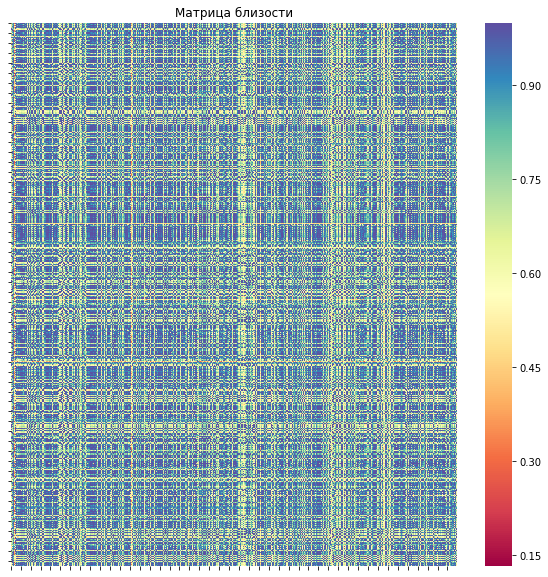

In [34]:
plt.figure(figsize = (10,10))
sns.heatmap(data=sims, cmap = 'Spectral').set(xticklabels=[], yticklabels=[])
plt.title("Матрица близости")
plt.show()

Выглядит опять не очень впечатляюще. Возможно, если уметь обращаться с LSI, будет лучше. 
Разделение на train и test кажется не обязательным, здесь это было сделано скорее из-за проблем с памятью. 

Также возможно, что модель скрытых тем была бы полезнее, если бы мы не знали тем, которые должны быть присвоены нашим текстам -- тогда на основе полученных данных эти темы можно было бы смоделировать. Возможно, с помощью LSI также можно находить новые ключевые слова для тем, но выше показанный пример не самый хорошо работающий. 

## Задание 7 [4 балла]. Continious bag of words
Для baseline решения мы использовали обычное представление текста в виде мешка слов. Попробуйте использовать другие модели представления текста – например, в виде непрерывного мешка слов, то есть, в виде набора эмбеддингов. Для того, чтобы получить вектор текста попробуйте:
* усреднить все эмбеддинги слов, входящих в этот текст
* усреднить все эмбеддинги слов, входящих в этот текст с $tf-idf$ весами
* использовать любую модель эмбеддинга документа.

Используйте любую модель эмбеддингов по вашему вкусу. 


Оцените результаты классификации по стандартным мерам качества и проведите анализ ошибок. Для этого рекомендуем визуализировать матрицу ошибок (confusion matrix). 

In [89]:
from gensim.models.doc2vec import TaggedDocument

In [126]:
train_tagged = []
train_corpus = []
for i, document in enumerate(list(X_train)):
    train_corpus.append([document.split(), [list(y_train)[i]]])
    train_tagged.append(TaggedDocument(document.split(), [list(y_train)[i]]))

In [127]:
train_tagged[1]

TaggedDocument(words=['писатель', 'алан', 'милна', 'автор', 'знаменитый', 'история', 'о', 'винни-пух', 'и', 'он', 'друг', 'родиться', 'в', 'большой', 'семья', 'биограф', 'предполагать', 'что', 'родитель', 'не', 'смочь', 'дать', 'алан', 'ощущение', 'любовь', 'и', 'поддержка', 'поэтому', 'он', 'весь', 'жизнь', 'доказывать', 'что', 'достойный', 'её', 'преодолевать', 'трудность', 'и', 'соперничать', 'с', 'брат', 'однажды', 'алан', 'увидеть', 'как', 'он', 'брат', 'кен', 'трудиться', 'над', 'письмо', 'девушка', 'в', 'который', 'быть', 'влюбить', 'легко', 'и', 'непринуждённо', 'кен', 'писать', 'текст', 'лёгкое', 'стих', 'алан', 'решить', 'показать', 'брат', 'что', 'он', 'тоже', 'по', 'сила', 'такой', 'задача', 'он', 'сесть', 'за', 'стол', 'и', 'весь', 'ночь', 'писать', 'письмо', 'кен', 'оформлять', 'текст', 'такой', 'же', 'стих', 'возможно', 'именно', 'это', 'письмо', 'и', 'вдохновить', 'он', 'стать', 'писатель', 'и', 'развить', 'свой', 'литературный', 'талант', 'цитатывеликий'], tags=['russi

In [128]:
test_corpus = []
test_tagged = []

for i, document in enumerate(list(X_test)):
    test_corpus.append([document.split(), [list(y_test)[i]]])
    test_tagged.append(TaggedDocument(document.split(), [list(y_test)[i]]))

In [130]:
model = Doc2Vec(train_tagged, vector_size=5, window=4, min_count=1)

In [131]:
from gensim.test.utils import get_tmpfile
fname = get_tmpfile("doc2vec_model")
model.save(fname)
model = Doc2Vec.load(fname)

Дальше начались проблемы с использованием модели и этот раздел остался незаконченным. 

## Конец

**Итоги**

Наиболее эффективным из того, что я использовала, оказалось использование логистической регрессии с лемматизацией (при это снижение размерности практически никак не влияет на итоговый результат, как и изменение длины n-gram при векторизации).  

Использованная модель скрытых тем оказалась достаточно неэффективной.

Хорошо работали и простые правила (использование самых частотных слов), но это, скорее всего, обусловлено характером самих текстов, в которых часто использовались хештеги, включавшие как раз частотные существительные.